# Novel Drug Approvals (2015 - 2024)

> **Goal:** This notebook will look at New Molecular Entities (NMEs) approved by the FDA. <br>
> **Notebook Owner(s):** Time Bioventures <br>
> **Date:** June 2024 <br>

***
## Import Libraries

Import the libraries you will be using throughout the project.

In [1]:
import os
import sys
import time
import datetime
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

***
## Scrape NME Tables

Utilize [BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/) to scrape all the NME tables (example: [2024 NMEs](https://www.fda.gov/drugs/novel-drug-approvals-fda/novel-drug-approvals-2024)) row-by-row, making sure you also capture the links for additional drug information.

In [60]:
def initialize_df():
	df = pd.DataFrame({
		"year": [],
		"year_approval_count": [],
		"drug_name": [],
		"active_ingredient": [],
		"approval_date": [],
		"approved_use": [],
		"drug_link": [],
		"press_release": [],
		"drug_trials_snapshot": []
	})
	return df

def scrape_drug_cols(cols):
	drug_dict = {
		"drug_name": None,
		"active_ingredient": None,
		"approval_date": None,
		"approved_use": None,
		"drug_link": None,
		"press_release": None,
		"drug_trials_snapshot": None
	}

	base_link = "https://www.fda.gov"

	# some rows have only active-ingredient (i.e. asuvimab-zykl) and no other info
	if len(cols) < 5 or cols[0].get_text().strip() == "*":
		return drug_dict
	# most drugs have 5 columns
	if len(cols) == 5:
		year_index, drug_name_index, active_ingredient_index, approval_date_index, approved_use_index = 0, 1, 2, 3, 4
	else:
		year_index, drug_name_index, active_ingredient_index, approval_date_index, approved_use_index = 0, 1, 2, 4, 5
	# year drug count
	drug_dict['year_index'] = cols[year_index].get_text().strip().replace('.', '')
	# drug name
	drug_dict['drug_name'] = cols[drug_name_index].get_text().strip()
	# drug link (if available)
	if len(cols[drug_name_index].find_all("a")) > 0:
		drug_dict['drug_link'] = cols[drug_name_index].find("a")["href"].strip()
	# active ingredient
	drug_dict['active_ingredient'] = cols[active_ingredient_index].get_text().strip()
	# for only one drug, the drug_link is in the active ingredient 
	if len(cols[active_ingredient_index].find_all("a")) > 0:
		drug_link = cols[active_ingredient_index].find("a")["href"].strip()
	# approval date
	approval_date = cols[approval_date_index].get_text().strip()
	# see if the date is in m/d/Y or m/d/y format
	if len(approval_date.split("/")[2]) == 4:
		# convert d/m/y to YYYY-MM-DD format
		drug_dict['approval_date'] = datetime.datetime.strptime(approval_date, "%m/%d/%Y").strftime("%Y-%m-%d")
	elif len(approval_date.split("/")[2]) == 2:
		drug_dict['approval_date'] = datetime.datetime.strptime(approval_date, "%m/%d/%y").strftime("%Y-%m-%d")
	# FDA made a mistake on Firdapse approval date stating 2028 instead of 2018 and Jardiance approval date stating 2104 instead of 2014
	if drug_dict['drug_name'] == "Firdapse":
		drug_dict['approval_date'] = drug_dict['approval_date'].replace("2028", "2018")
	if drug_dict['drug_name'] == "Jardiance":
		drug_dict['approval_date'] = drug_dict['approval_date'].replace("2104", "2014")
	# approved use
	drug_dict['approved_use'] = cols[approved_use_index].get_text().strip()
	# approved use links
	approved_use_links = cols[approved_use_index].find_all("a")
	# get hrefs for approved use links
	approved_use_hrefs = [a["href"] for a in approved_use_links]
	drug_dict['press_release'] = None
	drug_dict['drug_trials_snapshot'] = None
	for i, link in enumerate(approved_use_hrefs):
		if 'news-events' in link:
			# few of the links sporadically have the base_link already 
			drug_dict['press_release'] = base_link + link.replace('base_link', '')
		elif 'drug-trials' in link:
			drug_dict['drug_trials_snapshot'] = base_link + link.replace('base_link', '')
	return drug_dict

def scrape_fda_nce(year, url, df_all):
	response = requests.get(url)
	soup = BeautifulSoup(response.text, "html.parser")
	df_year = initialize_df()
	if year is None:
		# get year from the h1 tag
		year = str(int(soup.find_all("h1")[0].get_text().split(" ")[-1]))
	# scraping table and converting to dataframe had errors due to extra rows in some drug entries
	table = soup.find_all("table")[0]
	# iterate through each row in the table and get the text and link(s) for each drug
	rows = table.find_all("tr")
	print(f'  Number of rows: {len(rows)}')
	for rix, row in enumerate(rows):
		drug_dict = scrape_drug_cols(row.find_all("td"))
		if url == 'http://wayback.archive-it.org/7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm285554.htm':
			continue
		if not drug_dict["drug_name"]:
			continue
		df = pd.DataFrame({
			"year": [year],
			"year_approval_count": drug_dict['year_index'],
			"drug_name": drug_dict['drug_name'],
			"active_ingredient": drug_dict['active_ingredient'],
			"approval_date": drug_dict['approval_date'],
			"approved_use": drug_dict['approved_use'],
			"drug_link": drug_dict['drug_link'],
			"press_release": drug_dict['press_release'],
			"drug_trials_snapshot": drug_dict['drug_trials_snapshot']
		})
		df_year = pd.concat([df_year, df], ignore_index=True)
	return df_year

def scrape_recent_drugs():
	# get currrent year
	curr_year = datetime.datetime.now().year
	df_recent = pd.DataFrame()
	for year in range(2015, curr_year+1):
		print(f'Scraping drugs for year {year}...')
		url = f"https://www.fda.gov/drugs/novel-drug-approvals-fda/novel-drug-approvals-{year}"
		df = scrape_fda_nce(str(int(year)), url, df_all)
		df_recent = pd.concat([df_recent, df], ignore_index=True)
	return df_recent

def scrape_archived_drugs():
	base_link = 'http://wayback.archive-it.org'
	url = "https://wayback.archive-it.org/7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm483775.htm"
	df_archived = pd.DataFrame()
	response = requests.get(url)
	soup = BeautifulSoup(response.text, "html.parser")
	# find all links
	links = soup.find_all("a")
	# get all links with "Novel Drug Approvals for" in the text
	links = [link for link in links if "Novel Drug Approvals for" in link.get_text()]
	# get the hrefs for the links
	links = [base_link + link["href"] for link in links]
	for link in links:
		print(f'Scraping archived drugs from {link}...')
		df = scrape_fda_nce(None, link, df_archived)
		if df['drug_name'].isnull().all():
			continue
		df_archived = pd.concat([df_archived, df], ignore_index=True)
	return df_archived

def clean_df(df):
	print('Cleaning dataframe...')
	print(f' Number of rows before cleaning: {len(df)}')
	# convert year to int
	df['year'] = df['year'].astype(int)
	# convert year_approval_count to int and remove punctuation
	df['year_approval_count'] = df['year_approval_count'].str.replace(',', '').astype(int)
	# remove any duplicate rows with the same active_ingredient 
	df = df.drop_duplicates(subset=['active_ingredient'], keep='first')
	# sort by year and drug name
	df = df.sort_values(by=['year', 'year_approval_count'])
	# reset index
	df = df.reset_index(drop=True)
	print(f' Number of rows after cleaning: {len(df)}')
	return df

def scrape_nce():
	df_recent = scrape_recent_drugs()
	print('Number of recent drugs:', len(df_recent))
	df_archived = scrape_archived_drugs()
	print('Number of archived drugs:', len(df_archived))
	df_all = pd.concat([df_recent, df_archived], ignore_index=True)
	df_all = clean_df(df_all)
	return df_all

df_all = scrape_nce()

Scraping drugs for year 2015...
  Number of rows: 46
Scraping drugs for year 2016...
  Number of rows: 23
Scraping drugs for year 2017...
  Number of rows: 47
Scraping drugs for year 2018...
  Number of rows: 60
Scraping drugs for year 2019...
  Number of rows: 49
Scraping drugs for year 2020...
  Number of rows: 55
Scraping drugs for year 2021...
  Number of rows: 51
Scraping drugs for year 2022...
  Number of rows: 38
Scraping drugs for year 2023...
  Number of rows: 56
Scraping drugs for year 2024...
  Number of rows: 17
Number of recent drugs: 429
Scraping archived drugs from http://wayback.archive-it.org/7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm483775.htm...
  Number of rows: 19
Scraping archived drugs from http://wayback.archive-it.org/7993/20161022052127/http://www.fda.gov/Drugs/DevelopmentApprovalProcess/DrugInnovation/ucm430302.htm...
  Number of rows: 46
Scraping archived drugs from http://wayback.archive-it.org/7993/2016102205

In [62]:
df_all.head(10)

,year,year_approval_count,drug_name,active_ingredient,approval_date,approved_use,drug_link,press_release,drug_trials_snapshot
0,2012,1,Voraxaze,glucarpidase,2012-01-17,To treat patients with toxic levels of methotrexate in their blood due to kidney failure. Press Release,http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=125327&SearchType=BasicSearch,None,None
1,2012,2,Picato,ingenol mebutate,2012-01-23,For the topical treatment of actinic keratosis.,http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202833&SearchType=BasicSearch,None,None
2,2012,3,Inlyta,axitinib,2012-01-27,To treat patients with advanced kidney cancer (renal cell carcinoma) who have not responded to another drug for this type of cancer.Press Release,http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202324&SearchType=BasicSearch,None,None
3,2012,4,Erivedge,vismodegib,2012-01-30,"To treat adult patients with basal cell carcinoma, the most common type of skin cancer.Press Release",http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=203388&SearchType=BasicSearch,None,None
4,2012,5,Kalydeco,ivacaftor,2012-01-31,For the treatment of a rare form of cystic fibrosis (CF) in patients ages 6 years and older who have the specific G551D mutation in the Cystic Fibrosis Transmembrane Regulator (CFTR) gene. Press Release,,None,None
5,2012,6,Zioptan,tafluprost,2012-02-10,For reducing elevated intraocular pressure in patients with open-angle glaucoma or ocular hypertension.Press Release,http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202514&SearchType=BasicSearch,None,None
6,2012,7,Surfaxin,lucinactant,2012-03-06,"For the prevention of respiratory distress syndrome (RDS), a breathing disorder that affects premature infants.Press Release",http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=021746&SearchType=BasicSearch,None,None
7,2012,8,Omontys,peginesatide,2012-03-27,"To treat anemia, a condition in which the body does not have enough healthy red blood cells, in adult dialysis patients who have chronic kidney disease (CKD).Press Release",http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202799&SearchType=BasicSearch,None,None
8,2012,9,Amyvid,Florbetapir F 18,2012-04-06,Used as a radioactive diagnostic agent for Positron Emission Tomography (PET) imaging of the brain to estimate β-amyloid neuritic plaque density in adult patients with cognitive impairment who are being evaluated for Alzheimer’s Disease (AD) and other causes of cognitive decline.,http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202008&SearchType=BasicSearch,None,None
9,2012,10,Stendra,avanafil,2012-04-27,To treat erectile dysfunction.Press Release,http://wayback.archive-it.org/7993/20161022052138/http://www.accessdata.fda.gov/scripts/cder/drugsatfda/index.cfm?fuseaction=Search.SearchAction&searchTerm=202276&SearchType=BasicSearch,None,None


***
## View Output Table

In [63]:
# set max width of columns to 1000
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)
df_all.tail(20)

,year,year_approval_count,drug_name,active_ingredient,approval_date,approved_use,drug_link,press_release,drug_trials_snapshot
517,2023,52,Ogsiveo,nirogacestat,2023-11-27,To treat adults with progressing desmoid tumors who require systemic treatmentDrug Trials Snapshot,https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/217677s000lbl.pdf,None,https://www.fda.gov/drugs/drug-approvals-and-databases/drug-trials-snapshots-ogsiveo
518,2023,53,Fabhalta,iptacopan,2023-12-05,To treat paroxysmal nocturnal hemoglobinuria,https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/218276s000lbl.pdf,None,None
519,2023,54,Filsuvez,birch triterpenes,2023-12-18,To treat wounds associated with dystrophic and junctional epidermolysis bullosaDrug Trials Snapshot,https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/215064s000lbl.pdf,None,https://www.fda.gov/drugs/drug-approvals-and-databases/drug-trials-snapshots-filsuvez
520,2023,55,Wainua,eplontersen,2023-12-21,To treat polyneuropathy of hereditary transthyretin-mediated amyloidosisDrug Trials Snapshot,https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/217388s000lbl.pdf,None,https://www.fda.gov/drugs/drug-approvals-and-databases/drug-trials-snapshots-wainua
521,2024,1,Zelsuvmi,berdazimer,2024-01-05,To treat molluscum contagiosumDrug Trials Snapshot,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/217424s000lbl.pdf,None,https://www.fda.gov/drugs/drug-approvals-and-databases/drug-trials-snapshots-zelsuvmi
522,2024,2,Exblifep,"cefepime, enmetazobactam",2024-02-22,To treat complicated urinary tract infections,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/216165s000lbl.pdf,None,None
523,2024,3,Letybo,letibotulinumtoxinA-wlbg,2024-02-29,To temporarily improve the appearance of moderate-to-severe glabellar linesDrug Trials Snapshot,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/761225s000lbl.pdf,None,https://www.fda.gov/drugs/drug-approvals-and-databases/drug-trials-snapshots-letybo
524,2024,4,Tevimbra,tislelizumab-jsgr,2024-03-13,To treat unresectable or metastatic esophageal squamous cell carcinomaDrug Trials Snapshot,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/761232Orig1s000lbl.pdf,None,https://www.fda.gov/drugs/drug-approvals-and-databases/drug-trials-snapshots-tevimbra
525,2024,5,Rezdiffra,resmetirom,2024-03-14,To treat noncirrhotic non-alcoholic steatohepatitis with moderate to advanced liver scarringPress Release,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/217785s000lbl.pdf,https://www.fda.gov/news-events/press-announcements/fda-approves-first-treatment-patients-liver-scarring-due-fatty-liver-disease,None
526,2024,6,Tryvio,aprocitentan,2024-03-19,To treat hypertension,https://www.accessdata.fda.gov/drugsatfda_docs/label/2024/217686s000lbl.pdf,None,None


***
## Plot Yearly Approval Numbers

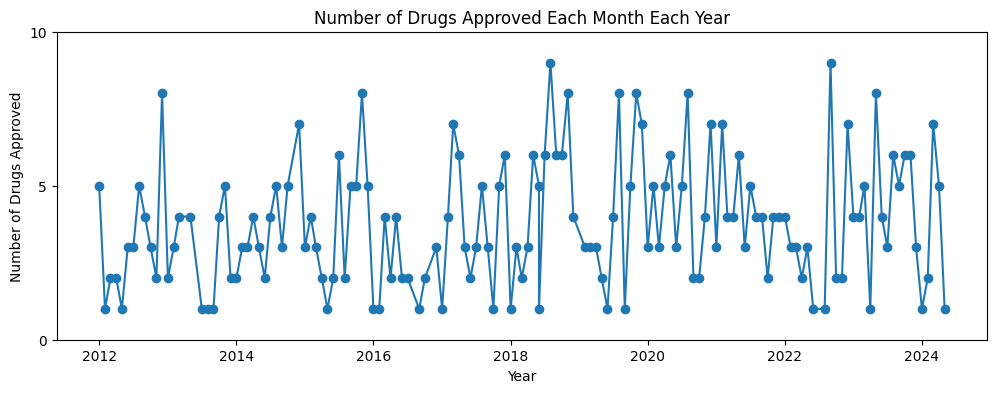

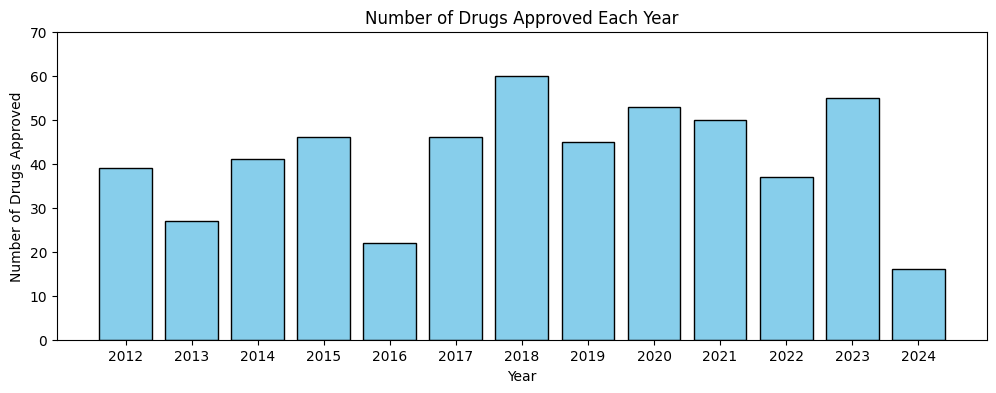

In [64]:
# plot number of drugs approved each month each year
def plot_nce_monthly(df_all):

	# convert approval_date to datetime
	approval_dates = pd.to_datetime(df_all['approval_date'])
	df_all['year_month'] = approval_dates.dt.to_period('M')
	df_all['year_month'] = df_all['year_month'].dt.to_timestamp()
	df_all['year_month'] = df_all['year_month'].dt.strftime('%Y-%m')
	df_all['year_month'] = pd.to_datetime(df_all['year_month'])
	df_all['year_month'] = df_all['year_month'].dt.strftime('%Y-%m')
	df_all['year_month'] = pd.to_datetime(df_all['year_month'])
	df_all['count'] = 1
	df_all_grouped = df_all.groupby(['year_month', 'year']).count().reset_index()
	df_all_grouped = df_all_grouped[['year_month', 'count']]
	# plot
	f, ax = plt.subplots(1, 1, figsize=(12, 4))
	ax.plot(df_all_grouped['year_month'], df_all_grouped['count'], marker='o')
	# show each month-year on x-axis
	ax.set_xlabel('Year')
	ax.set_ylabel('Number of Drugs Approved')
	ax.set_title('Number of Drugs Approved Each Month Each Year')
	ax.set_ylim(0, 10)
	# y-axis shows 0-5-10
	ax.set_yticks(range(0, 11, 5))

def plot_yearly(df_all_grouped):
	# plot the number of drugs approved each year
	f, ax = plt.subplots(1, 1, figsize=(12, 4))
	ax.bar(df_all_grouped['year'], df_all_grouped['count'], ec='black', color='skyblue')
	# show each year on x-axis
	ax.set_xlabel('Year')
	ax.set_ylabel('Number of Drugs Approved')
	ax.set_title('Number of Drugs Approved Each Year')
	# show all years
	ax.set_xticks(df_all_grouped['year'])
	ax.set_ylim(0, 70)
	# y-axis shows 0-50-100
	ax.set_yticks(range(0, 80, 10))
	plt.show()

def group_by_year(df_all):
	df_all['approval_date'] = pd.to_datetime(df_all['approval_date'])
	df_all['year'] = df_all['approval_date'].dt.year
	df_all['month'] = df_all['approval_date'].dt.month
	df_all_grouped = df_all.groupby(['year']).count().reset_index()
	df_all_grouped = df_all_grouped[['year', 'drug_name']]
	df_all_grouped.columns = ['year', 'count']
	return df_all_grouped

plot_nce_monthly(df_all)

df_all_grouped = group_by_year(df_all)
plot_yearly(df_all_grouped)


In [65]:
# write to csv
df_all.to_csv('fda_nce.csv', index=False)